In [1]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
!pip install mlflow
!pip install parsenvy

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve

import tensorflow as tf
import keras 

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, InputLayer, Flatten, Conv2D, MaxPooling2D, concatenate, Input, Average, LocallyConnected2D, BatchNormalization

np.random.seed(42)
tf.random.set_seed(42)

from getdata import *

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import mlflow
from config import TRACKING_URI, EXPERIMENT_NAME
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

mlflow.start_run(run_name='MultiInputCNN')

mlflow.tensorflow.autolog()

d=1
N=0
mlflow.log_params({"N": N})
mlflow.log_params({"d": d})
mlflow.set_tag("Dataset", 'both')

In [94]:
df = pd.read_csv('df_ADNI_modelling.csv')

In [95]:
df_train = df[df['Train'] == True]
df_test = df[df['Train'] == False]

In [96]:
X_train0 = get_slices_ADNI_new(df_train['ID'], dim=0, m=90)
X_train1 = get_slices_ADNI_new(df_train['ID'], dim=1, m=110)
X_train2 = get_slices_ADNI_new(df_train['ID'], dim=2, m=90)

X_test0 = get_slices_ADNI_new(df_test['ID'], dim=0, m=90)
X_test1 = get_slices_ADNI_new(df_test['ID'], dim=1, m=110)
X_test2 = get_slices_ADNI_new(df_test['ID'], dim=2, m=90)

In [97]:
def rep(X):
  return np.repeat(X[..., np.newaxis], 3, -1)

X_train0 = rep(X_train0)
X_train1 = rep(X_train1)
X_train2 = rep(X_train2)
X_test0 = rep(X_test0)
X_test1 = rep(X_test1)
X_test2 = rep(X_test2)

In [98]:
y_train = df_train['label']
X_train_df = df_train.drop(['ID', 'Sex', 'Imputed', 'label', 'Train'], axis=1)

y_test = df_test['label']
X_test_df = df_test.drop(['ID', 'Sex', 'Imputed', 'label', 'Train'], axis=1)

In [70]:
y_train.mean()

0.7183333333333334

In [99]:
Input0 = Input(shape=X_train0[0].shape, name='input0')
Input1 = Input(shape=X_train1[0].shape, name='input1')
Input2 = Input(shape=X_train2[0].shape, name='input2')
Inputdf = Input(shape=X_train_df.shape[1], name='inputdf')

b_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

for layer in b_model.layers:
    layer.trainable=False

def build_model(Input):
  x = b_model(Input)
  x = LocallyConnected2D(4, 3, 1, activation='relu')(x)
  x = Flatten()(x)
#  x = Dense(256, activation='relu')(x)
#  x = Dropout(0.2)(x)
  return x#Dense(16, activation='relu')(x)

x = concatenate([build_model(Input0), build_model(Input1), build_model(Input2), Inputdf])
#out = Average()(x)
#x = Dense(16, activation='relu')(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[Input0, Input1, Input2, Inputdf], outputs=out)

# Defining optimizer and learning rate
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.0001,
    decay_steps=10000,
    decay_rate=1,
    staircase=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

with tf.device('/device:GPU:0'):
  training = model.fit([X_train0, X_train1, X_train2, X_train_df], y_train, epochs=200, shuffle=True, validation_data=([X_test0, X_test1, X_test2, X_test_df], y_test), callbacks=callback)

Epoch 1/200
19/19 [==============================] - 7s 282ms/step - loss: 42985.7344 - accuracy: 0.7183 - val_loss: 42644.5117 - val_accuracy: 0.7200
Epoch 2/200
19/19 [==============================] - 4s 225ms/step - loss: 42429.6875 - accuracy: 0.7183 - val_loss: 42098.4062 - val_accuracy: 0.7200
Epoch 3/200
19/19 [==============================] - 4s 224ms/step - loss: 41893.1562 - accuracy: 0.7183 - val_loss: 41544.9141 - val_accuracy: 0.7200
Epoch 4/200
19/19 [==============================] - 4s 224ms/step - loss: 41341.5078 - accuracy: 0.7183 - val_loss: 41009.4336 - val_accuracy: 0.7200
Epoch 5/200
19/19 [==============================] - 4s 224ms/step - loss: 40802.9961 - accuracy: 0.7183 - val_loss: 40476.4414 - val_accuracy: 0.7200
Epoch 6/200
19/19 [==============================] - 4s 225ms/step - loss: 40262.7891 - accuracy: 0.7183 - val_loss: 39938.3828 - val_accuracy: 0.7200
Epoch 7/200
19/19 [==============================] - 4s 224ms/step - loss: 39728.8594 - accura

2022/09/02 13:40:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


KeyboardInterrupt: ignored

In [101]:
Input0 = Input(shape=X_train0[0].shape, name='input0')
Input1 = Input(shape=X_train1[0].shape, name='input1')
Input2 = Input(shape=X_train2[0].shape, name='input2')

b_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

for layer in b_model.layers:
    layer.trainable=False

def build_model(Input):
  x = b_model(Input)
  #x = LocallyConnected2D(4, 3, 1, activation='relu')(x)
  x = Flatten()(x)
#  x = Dense(256, activation='relu')(x)
#  x = Dropout(0.2)(x)
  return Dense(16, activation='relu')(x)

x = concatenate([build_model(Input0), build_model(Input1), build_model(Input2)])
#out = Average()(x)
#x = Dense(512, activation='relu')(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[Input0, Input1, Input2], outputs=out)

# Defining optimizer and learning rate
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.0001,
    decay_steps=1000,
    decay_rate=1,
    staircase=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

with tf.device('/device:GPU:0'):
  training = model.fit([X_train0, X_train1, X_train2], y_train, epochs=200, shuffle=True, validation_data=([X_test0, X_test1, X_test2], y_test), callbacks=callback)

Epoch 1/200
19/19 [==============================] - 6s 256ms/step - loss: 0.6158 - accuracy: 0.7183 - val_loss: 0.6085 - val_accuracy: 0.7200
Epoch 2/200
19/19 [==============================] - 4s 221ms/step - loss: 0.5712 - accuracy: 0.7183 - val_loss: 0.5787 - val_accuracy: 0.7200
Epoch 3/200
19/19 [==============================] - 4s 218ms/step - loss: 0.5556 - accuracy: 0.7250 - val_loss: 0.6068 - val_accuracy: 0.7200
Epoch 4/200
19/19 [==============================] - 4s 221ms/step - loss: 0.5651 - accuracy: 0.7250 - val_loss: 0.5730 - val_accuracy: 0.7200
Epoch 5/200
19/19 [==============================] - 4s 218ms/step - loss: 0.5278 - accuracy: 0.7417 - val_loss: 0.5784 - val_accuracy: 0.7050
Epoch 6/200
19/19 [==============================] - 4s 221ms/step - loss: 0.5096 - accuracy: 0.7483 - val_loss: 0.5674 - val_accuracy: 0.7150
Epoch 7/200
19/19 [==============================] - 4s 219ms/step - loss: 0.4940 - accuracy: 0.7617 - val_loss: 0.5718 - val_accuracy: 0.7250

2022/09/02 14:02:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


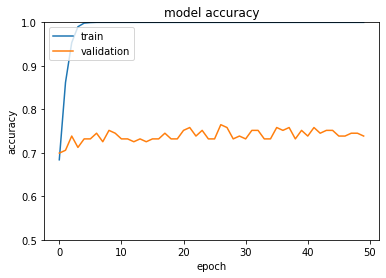

In [ ]:
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim([0.5,1.])
plt.show()

accuracy:  0.72
recall:  0.97
precision:  0.73


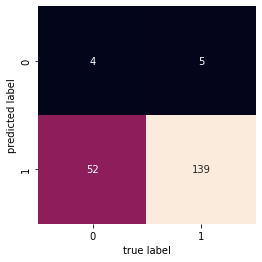

In [102]:
y_predd = model.predict([X_test0, X_test1, X_test2])
y_pred = (y_predd>0.5).astype(int)

# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred.round())
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test, y_pred.round()).round(2))
print('recall: ' , recall_score(y_test, y_pred.round()).round(2))
print('precision: ' , precision_score(y_test, y_pred.round()).round(2))

In [ ]:
mlflow.log_metric("test" + "-" + "acc", accuracy_score(y_test, y_pred.round()).round(2))
mlflow.log_metric("test" + "-" + "recall", recall_score(y_test, y_pred.round()).round(2))
mlflow.log_metric("test" + "-" + "precision", precision_score(y_test, y_pred.round()).round(2))
mlflow.end_run()

In [ ]:
model.save('multiinput')

In [10]:
a = 5

In [12]:
del a

In [13]:
a

NameError: ignored